In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tifffile
from scipy.signal import find_peaks
from skimage.measure import regionprops_table
from skimage.morphology import binary_dilation
from skimage.transform import rotate
import statannot

In [2]:
masks = tifffile.imread("segmentation_output/masks.tif")
image = tifffile.imread("segmentation_output/image.tif").astype(np.float64)
mask_labels = np.unique(masks)
def n_dilate(bin_image, n):
    for _ in range(n):
        bin_image = binary_dilation(bin_image)
    return bin_image

def smallestbox(a, b):
    r = a.any(1)
    if r.any():
        m,n = a.shape
        c = a.any(0)
        out = a[r.argmax():m-r[::-1].argmax(), c.argmax():n-c[::-1].argmax()]
        b  = b[:,r.argmax():m-r[::-1].argmax(), c.argmax():n-c[::-1].argmax()]
    else:
        out = np.empty((0,0),dtype=bool)
    return out, b

In [3]:
data= pd.read_pickle("output.pickle")
pixel_size = 0.065/1.5
data[["RADA", "HADA", "Average width", "RADA - HADA"]] *= pixel_size
data.to_pickle("plotting_data.pickle")
data = data.query("HADA < 0.8")

In [4]:
data

,idx,RADA,HADA,Average width,RADA - HADA
1,20,0.346667,0.433333,0.390000,-0.086667
2,27,0.606667,0.780000,0.693333,-0.173333
3,29,0.606667,0.736667,0.671667,-0.130000
5,39,0.650000,0.780000,0.715000,-0.130000
7,41,0.693333,0.780000,0.736667,-0.086667
...,...,...,...,...,...
199,800,0.476667,0.606667,0.541667,-0.130000
200,801,0.433333,0.476667,0.455000,-0.043333
201,805,0.346667,0.476667,0.411667,-0.130000
202,812,0.346667,0.433333,0.390000,-0.086667


Text(0, 0.5, 'Width offset (RADA - HADA)')

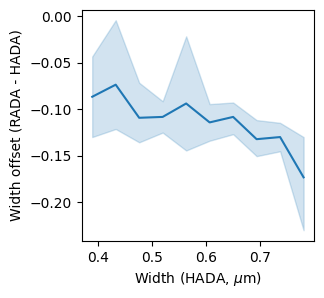

In [5]:
plt.figure(figsize=(3,3))
sns.lineplot(data = data, x = "HADA", y = "RADA - HADA")
plt.xlabel("Width (HADA, $\mu$m)")
plt.ylabel("Width offset (RADA - HADA)")

p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04



/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/statannot/statannot.py:555: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif text_format is 'star':
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/statannot/statannot.py:557: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif text_format is 'simple':
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/statannot/statannot.py:555: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif text_format is 'star':
/home/gh464/miniconda3/envs/symbac/lib/python3.10/site-packages/statannot/statannot.py:557: SyntaxWarning: "is" with a literal. Did you mean "=="?
  elif text_format is 'simple':


AttributeError: module 'seaborn.categorical' has no attribute '_BoxPlotter'

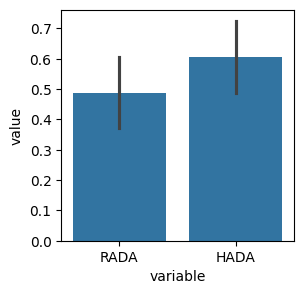

In [6]:
data_melt = data.melt()
data_melt = data_melt[data_melt["variable"].isin(["RADA", "HADA"])]
data_melt.to_pickle("barplot_data.pickle")
import scipy
stat, pvalue = scipy.stats.ttest_ind(data["RADA"], data["HADA"])
pvalue
fig, ax = plt.subplots(1,1, figsize=(3,3))
sns.barplot(data=data_melt, y = "value", x = "variable", errorbar="sd", ax=ax)
statannot.add_stat_annotation(
    ax,
    data=data_melt, y = "value", x = "variable",
    box_pairs=[
        (("HADA"), ("RADA")),
    ],
    test="t-test_ind",
    text_format="star",
    loc="outside",
)
plt.ylabel("Width ($\mu$m)")
plt.xlabel("FDAA")

In [7]:
def get_imgs_and_peaks(mask_label):
    b1, b2 = smallestbox(n_dilate(masks == mask_label,10), image)
    b2[1] -= np.sort(b2[1].flatten())[:int(len(b2[1].flatten())*0.05)].mean().astype(np.uint)
    b2[3] -= np.sort(b2[3].flatten())[:int(len(b2[3].flatten())*0.05)].mean().astype(np.uint)
    _ = smallestbox((masks == mask_label), image)[0]
    orientation = pd.DataFrame(regionprops_table(_*1, properties=["orientation"]))["orientation"][0]
    b1, b2 = rotate(b1, -orientation * 180/np.pi + 90), np.array([rotate(_, -orientation * 180/np.pi + 90) for _ in b2])
    centroid = regionprops_table(b1*1, properties=["centroid"])
    width = int(b2.shape[1]/10)
    
    centreline1 = b2[1,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)
    centreline2 = b2[3,:,int(centroid["centroid-1"])-width:int(centroid["centroid-1"])+width].mean(axis=1)
    
    
    centreline1_peaks = find_peaks(centreline1, prominence=0.006)[0]
    centreline2_peaks = find_peaks(centreline2, prominence=0.006)[0]
    return b2[1], b2[3], centreline1, centreline2
    #if (len(centreline1_peaks) == 2) and (len(centreline2_peaks) == 2):
    #    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    #    ax1.plot(centreline1,c="r")
    #    ax1.scatter(centreline1_peaks, centreline1[centreline1_peaks], c = "r")
    #    ax1.plot(centreline2,c="b")
    #    ax1.scatter(centreline2_peaks, centreline2[centreline2_peaks], c = "b")
    #    #ax1.legend(["red", "blue"])
    #    ax2.imshow(b2[1])
    #    ax3.imshow(b2[3])
    #    plt.tight_layout()
    #    plt.savefig(f"plots/{str(z).zfill(4)}.png")
    #    plt.close()
    #    #print("Red interpeak distance:", np.diff(centreline1_peaks))
    #    #print("Blue interpeak distance:", np.diff(centreline2_peaks))
    #    return [z, np.diff(centreline1_peaks)[0], np.diff(centreline2_peaks)[0]]
    

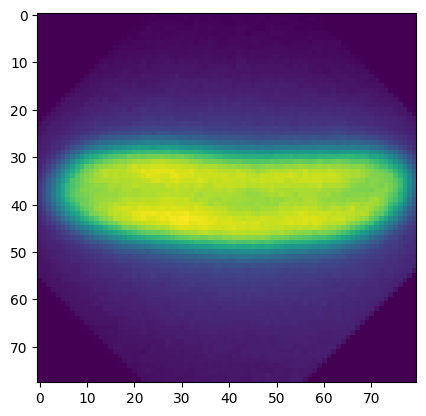

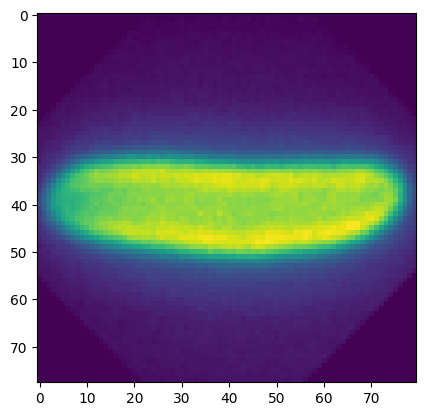

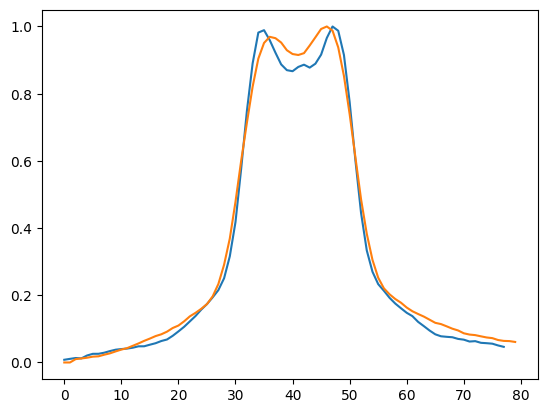

In [8]:
RADA_cell, HADA_cell, RADA_line, HADA_line = get_imgs_and_peaks(mask_labels[216+1]) #122 good
tifffile.imwrite("RADA_cell.tif", RADA_cell)
tifffile.imwrite("HADA_cell.tif", HADA_cell)
import pickle

with open('HADA_line.pickle', 'wb') as f:
    pickle.dump(HADA_line, f)
np.save("HADA_line.npy", HADA_line)

plt.imshow(RADA_cell, vmax=RADA_cell.max()/1)
plt.show()
plt.imshow(HADA_cell, vmax=HADA_cell.max())
plt.show()

RADA_line = np.concatenate([ [0]*2, RADA_line])

with open('RADA_line.pickle', 'wb') as f:
    pickle.dump(RADA_line, f)
    
np.save("RADA_line.npy", RADA_line)

plt.plot(HADA_line/HADA_line.max())
plt.plot(RADA_line/RADA_line.max())